In [ ]:
#!pip install egttools > /dev/null 2>&1

In [ ]:
import numpy as np
import egttools as egt
import matplotlib.pyplot as plt

## Functions for the creation of strategies list

To obtain all the possible strategies, we represent them using binary numbers.

The integers from 0 to nb_reaction_types - 1 encode all possible combinations of 0 and 1 for a given number of signals.

By converting each binary digit to a letter.

Mapping 0 → D (Defect) and 1 → C (Cooperate) we can generate the full set of strategies.

In [ ]:
def bin_to_letters(mu_bin: str):
    """
   Convert a binary string into a list of letters.

   Each '0' is mapped to 'D', and each '1' is mapped to 'C'.
   """
    letters = []
    for bit in mu_bin:
        if bit == '0':
            letters.append('D')
        if bit == '1':
            letters.append('C')
    return letters


def get_strategies_list(nb_signals: int):
    """
    Generate all possible strategies given a number of signals.

    Each strategy corresponds to a combination of:
      [signal, reaction to signal 1, ..., reaction to signal]
    """
    nb_reaction_types = 2 ** nb_signals  # number of possible type reaction

    strategies_list = []

    for i in range(nb_signals):
        signal_sent = str(i)
        for j in range(nb_reaction_types):
            binary_reaction = bin(j)[2:].zfill(nb_signals)
            letter_reaction = bin_to_letters(binary_reaction)  # es: letter_reaction = ('D','C','D')
            strategie = (signal_sent,) + tuple(letter_reaction)  #es: strategie = ('1','D','C','D')
            strategies_list.append(strategie)
    return strategies_list  # es: [('0', 'D', 'D', 'D'), ('0', 'D', 'D', 'C'), ...]

## Function for the creation of payoff matrix

In [ ]:
def build_payoff_matrix(strategies, parameters):
    """
    Construct the payoff matrix for a given set of strategies and game parameters (R, S, T, P).
    """
    R, S, T, P = parameters
    payoff_map = {('C', 'C'): R, ('C', 'D'): S, ('D', 'C'): T, ('D', 'D'): P}
    number_of_strategies = len(strategies)
    payoff_matrix = np.zeros((number_of_strategies, number_of_strategies))

    for i in range(number_of_strategies):
        for j in range(number_of_strategies):
            signal_sent_A = strategies[i][0]
            signal_sent_B = strategies[j][0]
            reaction_A = strategies[i][int(signal_sent_B) + 1]
            reaction_B = strategies[j][int(signal_sent_A) + 1]
            payoff_matrix[i, j] = payoff_map[(reaction_A, reaction_B)]

    return payoff_matrix

In [ ]:
egt.Random.init()
seed = egt.Random.seed

##
### Setting the parameters

In [ ]:
SH_parameters = (1, -0.5, 0.5, 0)

sigma = 2  # number of signal

Z = 150  # population

beta = 0.05  # noise of decision

### Calculating the stationary distribution
To determine the long-term behaviour of the population, we model the evolutionary dynamics as a reduced Markov chain within the framework of the Small Mutation Limit (SML).

We use egttools to compute the transition matrix (M) of this chain and subsequently derive the stationary distribution.

In [ ]:
strategies = get_strategies_list(sigma)

number_of_strategies = sigma * 2 ** sigma  # using the formula  equation n = σ*2^σ

payoff_matrix = build_payoff_matrix(strategies, SH_parameters)
game = egt.games.Matrix2PlayerGameHolder(number_of_strategies, payoff_matrix)

evolver = egt.analytical.PairwiseComparison(Z, game)
transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)  # considering the case of small-mutation limit
stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix.transpose())
stationary_distribution

array([0.08082186, 0.01914399, 0.27534331, 0.12469084, 0.08082186,
       0.27534331, 0.01914399, 0.12469084])

## Plotting the result

### Stationary distribution of every strategy

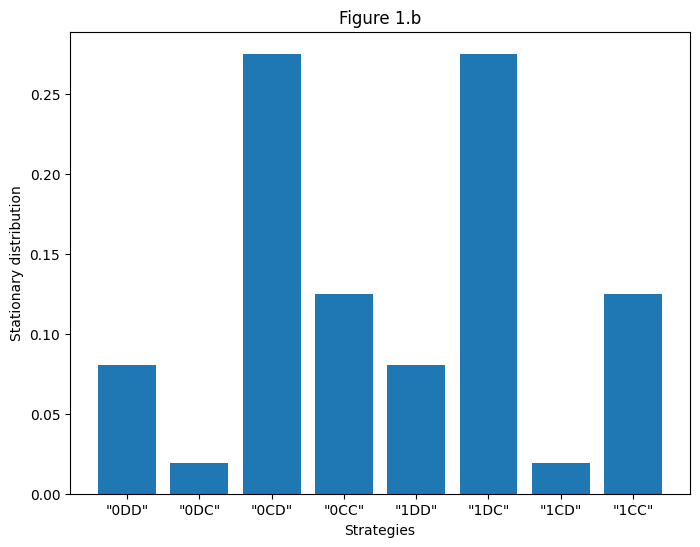

In [ ]:
strategies_name = []

for i in range(number_of_strategies):
    strategies_name.append(f"\"{''.join(str(reaction) for reaction in strategies[i])}\"")

plt.figure(figsize=(8, 6))
plt.bar(strategies_name, stationary_distribution)
plt.title('Figure 1.b')
plt.xlabel('Strategies')
plt.ylabel('Stationary distribution')
plt.show()

### Evolutionary dynamics with respect to each of the signals
We implement the function  𝑝𝜎 = ∑∀𝑠 𝑝𝑠 * 𝛿(𝜎𝑠 − 𝜎)

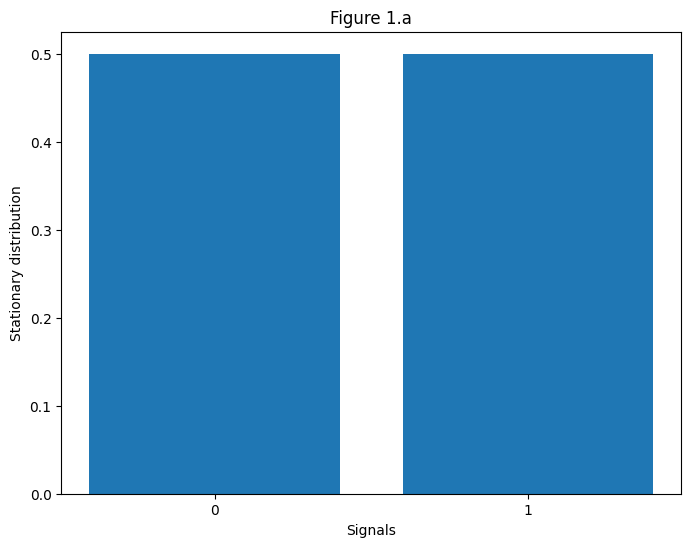

In [ ]:
signals = []
signals_probability = []
for signal in range(sigma):
    signals.append(signal)
    probability = 0
    for i in range(len(strategies)):
        x = 1 if signal == int(strategies[i][0]) else 0

        probability += stationary_distribution[i] * x
    signals_probability.append(probability)

plt.figure(figsize=(8, 6))
plt.bar([str(signals[0]), str(signals[1])], signals_probability)
plt.title('Figure 1.a')
plt.xlabel('Signals')
plt.ylabel('Stationary distribution')
plt.show()

### Accumulated frequencies of the four strategies in which individuals cooperate with each other under a monomorphic scenario
We implement the function 𝑝s = ∑∀𝑠 𝑝𝑠 * x with x = 1 if the signal sent by the strategy correspond to a played C in the strategy itself, 0 otherwise

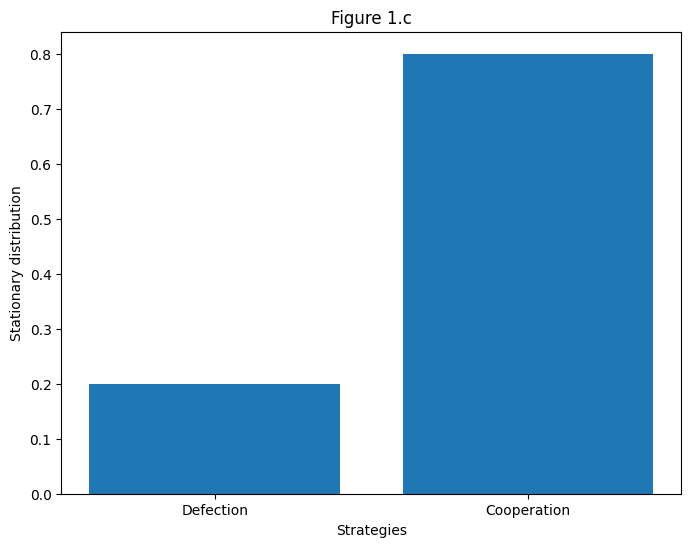

In [ ]:
cooperatoin_probability = 0
for i in range(len(strategies)):
    signal_sent = int(strategies[i][0])
    x = 1 if strategies[i][1 + signal_sent] == 'C' else 0
    cooperatoin_probability += stationary_distribution[i] * x
defection_probaility = 1 - cooperatoin_probability

plt.figure(figsize=(8, 6))
plt.bar(["Defection", "Cooperation"], [defection_probaility, cooperatoin_probability])
plt.title('Figure 1.c')
plt.xlabel('Strategies')
plt.ylabel('Stationary distribution')
plt.show()

### Invasion diagram
Now we plot the invasion diagram for 2 signals

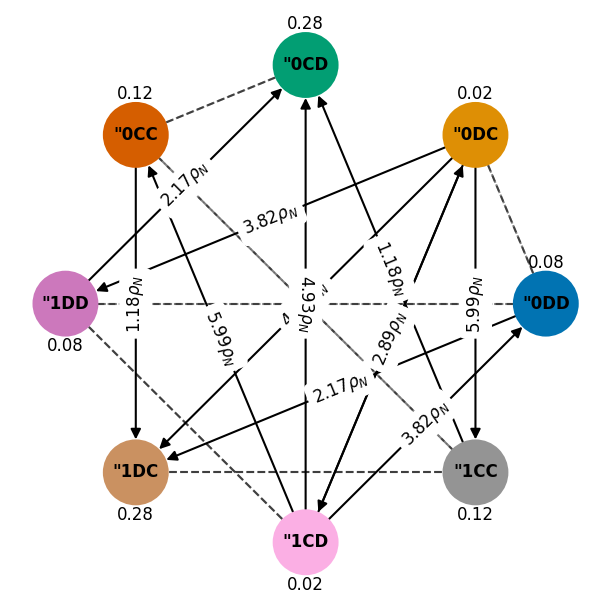

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = egt.plotting.draw_invasion_diagram(strategies_name,
                                       1 / Z, fixation_probabilities, stationary_distribution,
                                       node_size=1000,
                                       font_size_node_labels=8,
                                       font_size_edge_labels=8,
                                       font_size_sd_labels=8,
                                       edge_width=1,
                                       min_strategy_frequency=0.00001,
                                       ax=ax)
plt.axis('off')
plt.show()

<a id='s1'></a>
### Average fraction of time spent in monomorphic cooperative states

In [ ]:
from tqdm import tqdm

R = 1
P = 0
T_values = np.linspace(0, 1, 21)

cooperation = np.zeros((3, len(T_values)))

for sigma in tqdm(range(1, 4)):
    i = 0
    for T in T_values:
        strategies = get_strategies_list(sigma)

        number_of_strategies = sigma * 2 ** sigma
        payoff_matrix = build_payoff_matrix(strategies, (R, -T, T, P))
        game = egt.games.Matrix2PlayerGameHolder(number_of_strategies, payoff_matrix)

        evolver = egt.analytical.PairwiseComparison(Z, game)
        transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(beta)
        stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix.transpose())
        strategie_probability = []

        cooperation_probability = 0
        for j in range(len(strategies)):
            # delta is 1 if the signal sent by the strategy correspond to a played C in the strategy itself
            signal_sent = int(strategies[j][0])
            x = 1 if strategies[j][1 + signal_sent] == 'C' else 0
            cooperation_probability += stationary_distribution[j] * x
        cooperation[sigma - 1][i] = cooperation_probability
        i += 1

100%|██████████| 3/3 [01:08<00:00, 22.69s/it]


<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipython-input-4272755127.py:21: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel('Commitment cost $\epsilon$', fontsize=14)


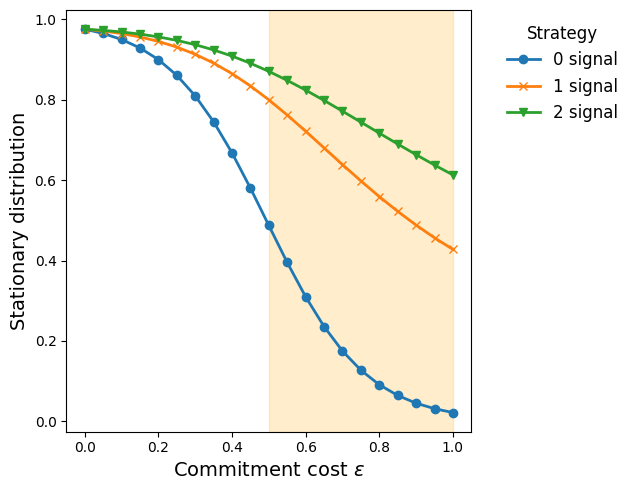

In [ ]:
import pandas as pd
import seaborn as sns

labels = ['epsilon'] + ['1 signal', '2 signal', '3 signal']
markers = ['o', 'x', 'v']


fig, ax = plt.subplots(figsize=(7, 5))

for i in range(3):
    ax.plot(T_values, cooperation[i, :], linewidth=2, label=f"{i} signal", marker=markers[i])


idx = np.argmin(np.abs(T_values - 0.5))

ax.axvspan(0.5, max(T_values), alpha=0.2, color='orange')

ax = plt.gca()

ax.set_ylabel('Stationary distribution', fontsize=14)
ax.set_xlabel('Commitment cost $\epsilon$', fontsize=14)
plt.legend(title="Strategy", loc='upper right', bbox_to_anchor=(1.4, 1), frameon=False, fontsize=12,
           title_fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig(
    f"./commitment_delta_{x}_Z_{Z}_beta_{beta}.png",
    bbox_inches='tight', dpi=300)

# Conclusion
The reproduction successfully validates the paper's central thesis: costless pre-play signaling facilitates the emergence of cooperation in the Stag Hunt (SH) game.

As demonstrated in the generated figures, the introduction of signals helps the population reach monomorphic cooperative states.
Crucially, increasing the number of available signals ($1, 2, 3$) significantly improves the resilience of cooperation, even at higher values of Temptation ($T$), as shown in the reproduction of Figure 4.

The introduction of signals generally favors the payoff combination with the higher value.
In the Stag Hunt ($R > T > P > S$), signals allow individuals to coordinate on the Pareto-efficient reward $R$, thus reinforcing cooperative equilibria.

Conversely, in the Prisoner's Dilemma ($T > R > P > S$), signals can be exploited; the incentive to deceive drives the population towards the temptation payoff $T$, often resulting in monomorphic non-cooperative states, although a high number of signals can mitigate this.

Finally, the analysis of the intensity of selection, $\beta$, highlights the sensitivity of the model to noise.
High $\beta$ values lead to pure imitation dynamics, whereas as $\beta \to 0$, the system moves towards random drift, reducing the selective pressure that favors profitable coordination.

Consequently, increasing $\beta$ strengthens the monomorphic cooperative states. This is evident when comparing the original paper's Figure 4 ($\beta = 0.1$) with our reproduction ($\beta = 0.05$); the higher selection intensity in the paper results in a sharper transition and stronger dominance of cooperation compared to the slightly noisier dynamics in our reproduction.